In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil

from tortoise.api import *
import torch
from tortoise.utils.audio import denormalize_tacotron_mel, normalize_tacotron_mel
from tortoise.translation_model.sanscript import transliterate, DEVANAGARI, HK
import glob
import matplotlib.pyplot as plt
import IPython

files = glob.glob('train/mels/inputs/*.pth')
data = [torch.load(f, map_location=torch.device('cpu'))[:2] for f in files[:300]]

wav_files = sorted(glob.glob('train/audio/*.wav'))
wav_files_and_speaker = [(f.split('/')[-1].split('_')[-1][:-4], f) for f in wav_files]
wav_files_per_speaker = {}
for speaker_id, f in wav_files_and_speaker:
    if speaker_id in wav_files_per_speaker:
        wav_files_per_speaker[speaker_id].append(f)
    else:
        wav_files_per_speaker[speaker_id] = [f]
        
speaker_id = '030'
if os.path.exists('tortoise/voices/temp_voice_folder'):
        shutil.rmtree('tortoise/voices/temp_voice_folder')
os.makedirs('tortoise/voices/temp_voice_folder', exist_ok=True)

for i, f in enumerate(wav_files_per_speaker[speaker_id][:3]):
    shutil.copyfile(f, f"tortoise/voices/temp_voice_folder/{i}.wav")

In [2]:
# tts = TextToSpeech(translation_model_path='models/basic_4layer_msedouble_700.pth')
tts = TextToSpeech(translation_model_path='models/basic_4layer_msedouble_overfit_6000.pth')

In [3]:
eng_text = None
hin_text = "बंदर ने पैर सहलाया"

assert eng_text is None or hin_text is None, "Text input should be in only one of english or devanagiri script, both provided"

if eng_text is None:
    eng_text = transliterate(hin_text, DEVANAGARI, HK).lower()

# Pick a "preset mode" to determine quality. Options: {"ultra_fast", "fast" (default), "standard", "high_quality"}. See docs in api.py
preset = "fast"
eng_text

'bamdara ne paira sahalaya'

In [4]:
# overfit
from tortoise.utils.audio import load_audio, load_voice, load_voices
voice = 'temp_voice_folder'

voice_samples, conditioning_latents = load_voice(voice)
gen = tts.tts_with_preset(eng_text, voice_samples=voice_samples, conditioning_latents=conditioning_latents, 
                          preset=preset)
torchaudio.save('generated.wav', gen.squeeze(0).cpu(), 24000)
IPython.display.Audio('generated.wav')

Generating autoregressive samples..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.79s/it]


Computing best candidates using CLVP and CVVP


  0%|                                                                                                                                                     | 0/6 [00:00<?, ?it/s]/n/home11/abanerjee/.conda/envs/snemi_new/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.00it/s]


Transforming autoregressive outputs into audio..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 22.51it/s]


Translating audio..


Generating autoregressive samples..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]


Computing best candidates using CLVP and CVVP


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.04it/s]


Transforming autoregressive outputs into audio..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 21.53it/s]


Translating audio..
> /net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/abanerjee/Tortoise/tortoise-tts/tortoise/api.py(471)tts()
    469                         print("Translating audio..")
    470                     import pdb; pdb.set_trace()
--> 471                     self.translation_model.cuda()
    472                     mel = self.translation_model(normalize_tacotron_mel(mel.cuda()), text_lats.cuda())
    473                     mel = clip_denormed_mel(denormalize_tacotron_mel(mel))

ipdb> n
> /net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/abanerjee/Tortoise/tortoise-tts/tortoise/api.py(472)tts()
    470                     import pdb; pdb.set_trace()
    471                     self.translation_model.cuda()
--> 472                     mel = self.translation_model(normalize_tacotron_mel(mel.cuda()), text_lats.cuda())
    473                     mel = clip_denormed_mel(denormalize_tacotron_mel(mel))
    474                     self.translation_model.cpu

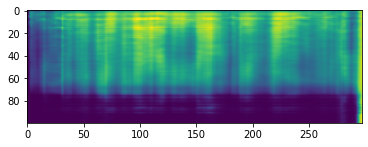

ipdb> plt.imshow(mel_old[0].cpu()); plt.pause(1)


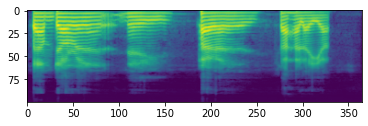

ipdb> c


In [12]:
# no overfit
from tortoise.utils.audio import load_audio, load_voice, load_voices
voice = 'temp_voice_folder'

voice_samples, conditioning_latents = load_voice(voice)
gen = tts.tts_with_preset(eng_text, voice_samples=voice_samples, conditioning_latents=conditioning_latents, 
                          preset=preset)
torchaudio.save('generated.wav', gen.squeeze(0).cpu(), 24000)
IPython.display.Audio('generated.wav')

## Translate Train Set

In [54]:
def clip_denormed_mel(mel):
    mel_sum = (mel[0] > -1).sum(0)
    
    for i, m in enumerate(torch.flip(mel_sum > 80, [0])):
        if not m:
            break
    return mel[...,:(-1-i)]

In [8]:
from translation_model.model import *

model = TranslationModel(4)
# model.load_state_dict(torch.load('models/basic_4layer_msedouble_700.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('models/basic_4layer_msedouble_overfit_6000.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
idx = 6
with torch.no_grad():
    gen = model(normalize_tacotron_mel(data[idx][0]), data[idx][1])

In [10]:
out = clip_denormed_mel(denormalize_tacotron_mel(gen))
wav = tts.vocoder.inference(out)

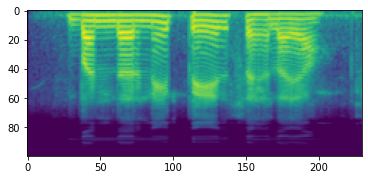

In [11]:
# overfit
plt.imshow(out[0])
torchaudio.save('gen.wav', wav.squeeze(0).cpu(), 24000)
IPython.display.Audio('gen.wav')

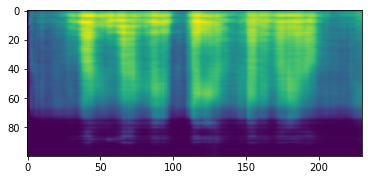

In [59]:
# no overfit
plt.imshow(out[0])
torchaudio.save('gen.wav', wav.squeeze(0).cpu(), 24000)
IPython.display.Audio('gen.wav')

## Orig

In [60]:
wav = tts.vocoder.inference(data[idx][0])

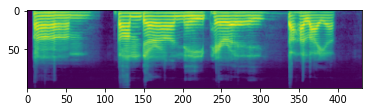

In [61]:
plt.imshow(data[idx][0][0])
torchaudio.save('gen.wav', wav.squeeze(0).cpu(), 24000)
IPython.display.Audio('gen.wav')

## Targ

In [62]:
t = torch.load(files[idx].replace('inputs', 'targs'), map_location=torch.device('cpu'))
wav = tts.vocoder.inference(t)

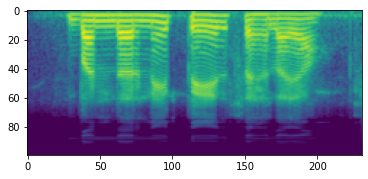

In [63]:
plt.imshow(t[0])
torchaudio.save('gen.wav', wav.squeeze(0).cpu(), 24000)
IPython.display.Audio('gen.wav')